# 0.0 - Imports

In [192]:
import math
import random
import warnings
import datetime
import inflection
import numpy as np
import pandas as pd
import xgboost as xbg
import seaborn as sns
import matplotlib.pyplot as plt

from boruta                import BorutaPy
from scipy                 import stats as ss
from tabulate              import tabulate
from IPython.core.display  import HTML
from IPython.core.display  import Image
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## 0.1 - Helper Functions

In [2]:
#%matplotlib inline
#%pylab inline
    
#plt.style.use('bmh')
#plt.rcParams['figure.figsize'] = [25, 12]
#plt.rcParams['font.size'] = 24
    
#display (HTML('<style>.container { width:100% !important; }</style>'))
#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#pd.set_option('display.expand_frame_repr', False)

In [3]:
display (HTML('<style>.container { width:100% !important; }</style>'))

In [193]:
def cross_validation(x_training, k_fold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, k_fold+1)):
        if verbose:
            print(f'KFold Number: {k}')
        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #predictions
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0] )


def mean_percentage_error_2(y, yhat):
    return np.mean( (y - yhat) /y )


def mean_absolute_percentage_error_2(y, yhat):
    return np.mean(np.abs( (y - yhat) /y ))




def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error_2(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])



def cramer_v(x, y):
    cm = pd.crosstab(x, y).values #as_matrix() saiu do pandas
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k -1)*(r-1)/(n-1))
    
    kcorr = k - (k -1)**2/(n-1)
    rcorr = r - (r -1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1) ) )



## 0.2 - Loading data

In [5]:
df_sales_raw = pd.read_csv('C:\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\data\\train.csv', low_memory=False)
df_store_raw = pd.read_csv('C:\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\data\\store.csv', low_memory=False)

In [6]:
#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 - PASSO 01 - Descrição dos dados

In [7]:
#copiar o dataframe pra manter sempre um registro de cada etapa separado do resultado da etapa anterior
df1 = df_raw.copy()

## 1.1 - Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2 - Data Dimensions

In [9]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 - Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Fillout NA

In [12]:
#competition_distance 
#-> Assumption: se o o maior valor da coluna é 70mil. 200mil seria o mesmo q dizer que a competição é o mínimo possível
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
#-> Assumption: Como não da pra saber se está NA pq:
               #  1 - Não existe competidor
               #  2 - O competidor abriu antes da loja
#Assim é melhor colocar a data da venda mais recente
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
#-> Assumption: Mesma lógica da de cima
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
#-> Assumption: Se está é NA é pq a lojo não participou da promoção
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
#-> Assumption: O mesmo da de cima
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
#-> Assumption: 
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if  x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 - Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 - Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Numeric Attributes

In [15]:
#central tendency - média e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']

In [16]:
m

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\galves\AppData\Local\Temp\ipykernel_6768\3919186694.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales']) #a distplot vai ser retirada do seaborn


<AxesSubplot:xlabel='sales', ylabel='Density'>

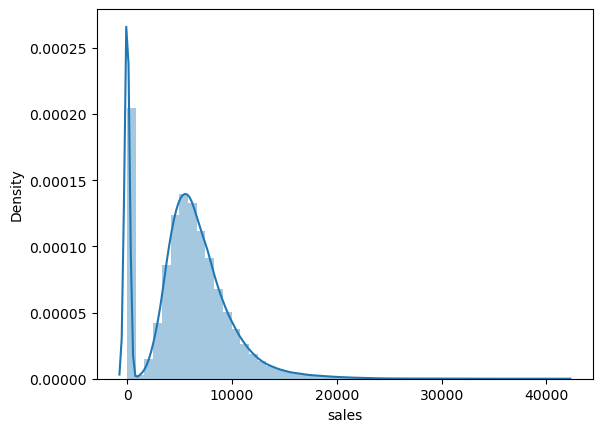

In [17]:
sns.distplot(df1['sales']) #a distplot vai ser retirada do seaborn
#sns.displot(df1['sales'])
#sns.histplot(df1['sales'])

### 1.7.2 - Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

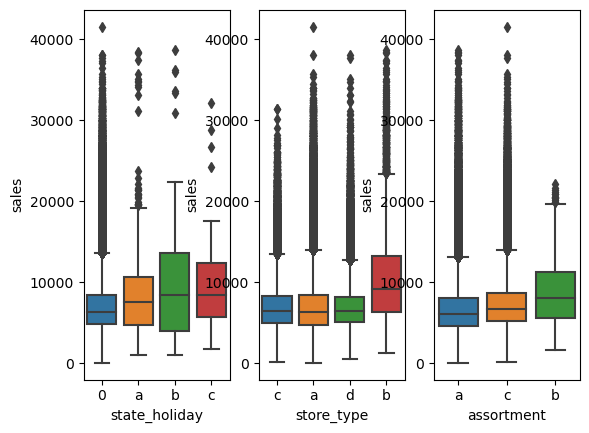

In [19]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# os pontilhados acima são os outliers (calculados automaticamente sendo acima de 3 vezes o desvio padrão)
# o traço no meio do retangulo colorido é o 50º quartil, é a mediana. Anterior tem o 25º quartil e depois tem o 75ºquartil

## 1.8 - 

In [20]:
#df1[(df1['state_holiday'] != 0)]

# 2.0 - PASSO 02 - Feature Engineering

In [21]:
df2 = df1.copy()

## 2.1 - Mapa mental de Hipóteses

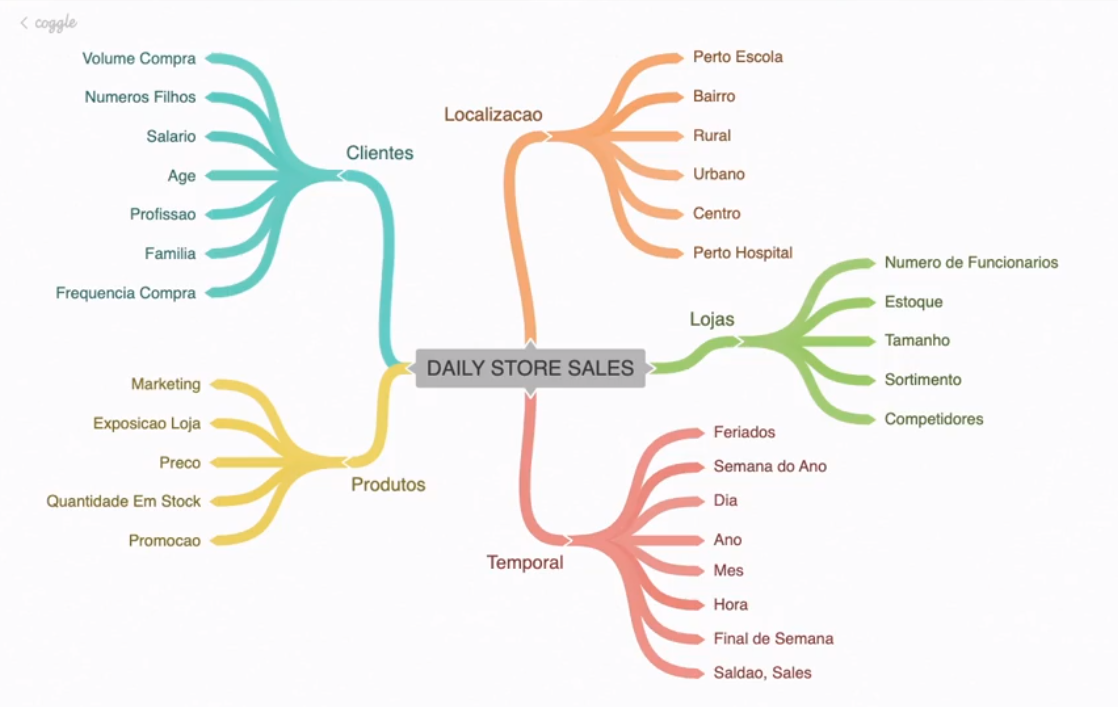

In [22]:
Image('C:\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto//img//mind_map_hypothesis.png')

## 2.2 - Criação das Hipóteses

### 2.2.1 - Hipóteses loja

**1.** Lojas com um **maior quadro de funcionários** deveriam **vender mais**

**2.** Lojas com **maior estoque** deveriam **vender mais**

**3.** Lojas com **maior porte** deveriam **vender mais**

**4.** Lojas com **menor porte** deveriam **vender menos**

**5.** Lojas com **maior sortiment**o deveriam **vender mais**

**6.** Lojas com **competidores mais próximos** deveriam **vender menos**

**7.** Lojas com **competidores à mais tempo** deveriam **vender mais**

### 2.2.2 - Hipóteses produto

**1.** Lojas investem mais em **marketing** deveriam **vender mais**

**2.** Lojas com maior **exposição de produtos** deveriam **vender mais**

**3.** Lojas que tem **preços menores** nos produtos deveriam **vender mais**

**4.** Lojas que tem **promoções mais agressivas** (descontos maiores) deveriam **vender mais**

**5.** Lojas que tem **promoções ativas por mais tempo** deveriam **vender mais**

**6.** Lojas que ficam **mais dias com promoção** deveriam **vender mais**

**7.** Lojas com mais **promoções consecutivas** deveriam **vender mais**

### 2.2.3 - Hipóteses Tempo

**1.** Lojas que **ficam abertas durante feriado de Natal** deveriam **vender mais**

**2.** Lojas deveriam **vender mais** ao **longo dos anos**

**4.** Lojas deveriam **vender mais** no **segundo semestre** do ano

**5.** Lojas deveriam **vender mais** **depois do dia 10** de cada mês

**6.** Lojas deveriam **vender menos** aos **finais de semana**

**7.** Lojas deveriam **vender menos** durante os **feriados escolares**





### 2.3 - Lista Final de Hipóteses 

**1.** Lojas com **maior sortimento** deveriam **vender mais**

**2.** Lojas com **competidores mais próximos** deveriam **vender menos**

**3.** Lojas com **competidores à mais tempo** deveriam **vender mais**

**4.** Lojas que tem **promoções ativas por mais tempo** deveriam **vender mais**

**5.** Lojas que ficam **mais dias com promoção** deveriam **vender mais**

**6.** Lojas com mais **promoções consecutivas** deveriam **vender mais**

**7.** Lojas que **ficam abertas durante feriado de Natal** deveriam **vender mais**

**8.** Lojas deveriam **vender mais** ao **longo dos anos**

**9.** Lojas deveriam **vender mais** no **segundo semestre** do ano

**10.** Lojas deveriam **vender mais** **depois do dia 10** de cada mês

**11.** Lojas deveriam **vender menos** aos **finais de semana**

**12.** Lojas deveriam **vender menos** durante os **feriados escolares**

## 2.4 - Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 - PASSO 03 - Filtragem de variáveis

In [24]:
df3 = df2.copy()

## 3.1 - Filtragem das linhas

In [25]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 - Seleção das colunas

In [26]:
#a coluna customers deve ser retirada pq como não vai ser possível ter os dados no momento da predição (seria necessário fazer uma previsão que gastaria muito tempo e não é necessário para essa etapa do processo)
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [27]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 - PASSO 04 - Análise Exploratória dos dados

In [30]:
df4 = df3.copy()

## 4.1 - Análise Univariada

### 4.1.1 - Response variable

C:\Users\galves\AppData\Local\Temp\ipykernel_6768\1570643180.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df4['sales'])) #se alterar para sns.distplot((df4['sales'], kde=False)) mostra o histograma


<AxesSubplot:xlabel='sales', ylabel='Density'>

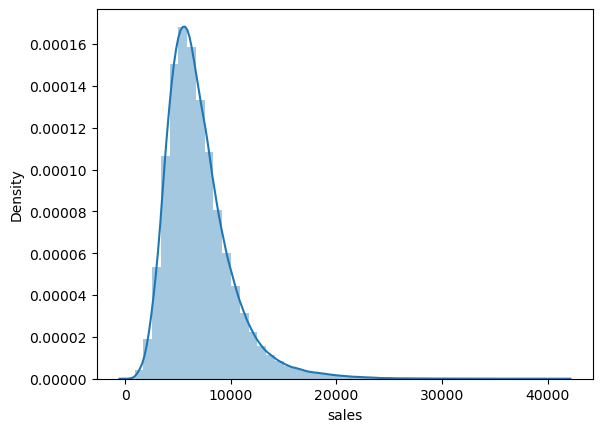

In [31]:
sns.distplot((df4['sales'])) #se alterar para sns.distplot((df4['sales'], kde=False)) mostra o histograma

#sns.distplot(np.log1p(df4['sales'])) multplica todos os valores pelo log

### 4.1.2 - Numeriacal variable

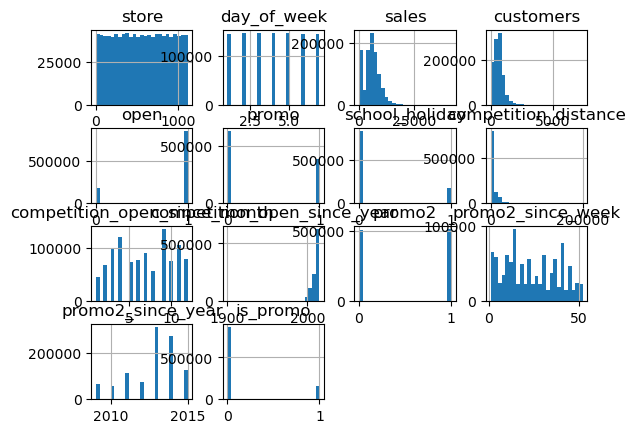

In [32]:
num_attributes.hist(bins=25);
plt.rcParams['figure.figsize'] = [15, 15] #[largura, altura]
plt.rcParams['figure.dpi'] = 200

### 4.1.3 - Categorical variable

In [33]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

KeyError: 0

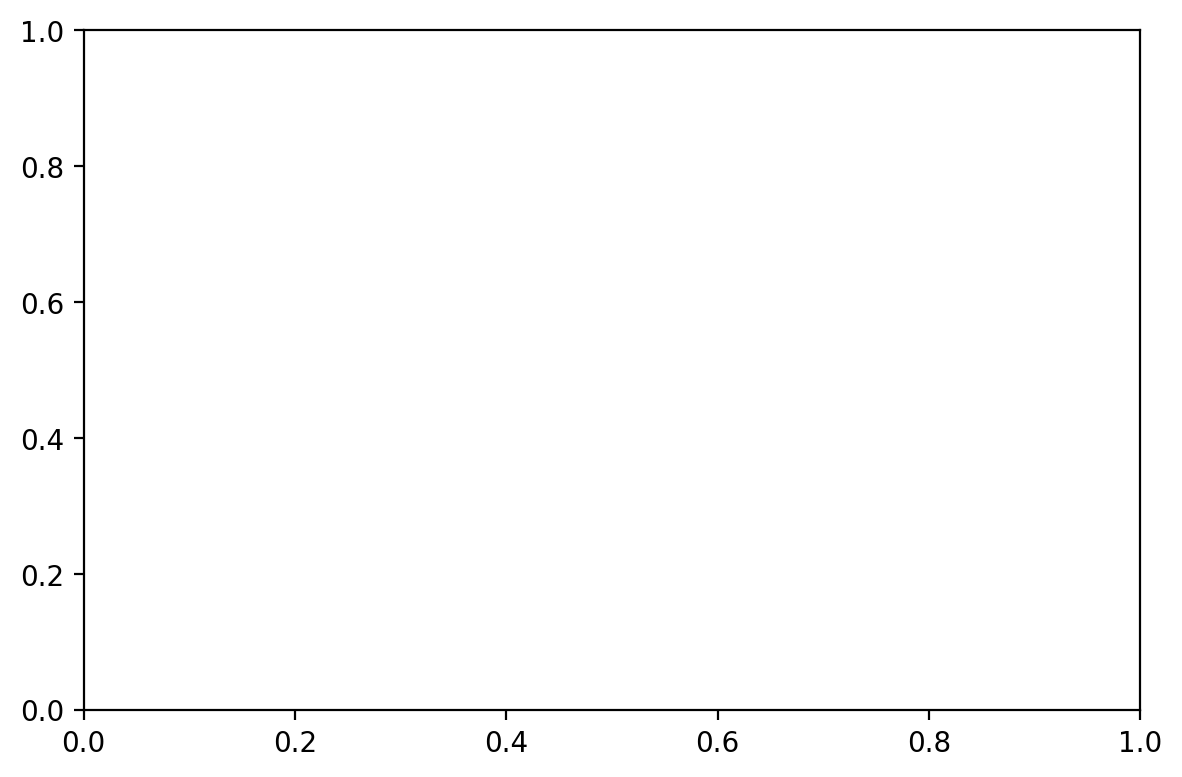

In [34]:
#state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)


#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)

## 4.2 - Análise Bivariada

### H1 - Lojas com maior sortimento deveriam vender mais
**FALSA** - Lojas com MAIOR SORTMENTO vendem MENOS

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

#Para observar a variação durante as semanas dos anos para cada um dos assortments
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

#Para observar melhor a linha do extra, já que ela estava muito reta antes
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2 - Lojas com competidores mais próximos deveriam vender menos
**FALSA** - Lojas com competidores mais próximos vendem mais

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
#Como da forma abaixo o gráfico fica muito granular é melhor separar a distancia em grupos, usando o bin
#aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
#sns.barplot(x='competition_distance', y='sales', data=aux1);

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
plt.xticks(rotation=90)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3 - Lojas com competidores à mais tempo deveriam vender mais
**FALSA** - Lojas com competidores à mais tempo vendem menos

In [ ]:
#competition_time_month representa a diferença entre a data observada com o dia q o competidor abriu (a distância entre uma data e a data de abertura do competidor)

plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H4 - Lojas que tem **promoções ativas por mais tempo** deveriam **vender mais**
**FALSA** - Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>H5 - Lojas que ficam **mais dias com promoção** deveriam **vender mais**</s>

### H6 - Lojas com mais **promoções consecutivas** deveriam **vender mais**
**FALSA** - Lojas com mais promoções consecutivas vendem menos

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales')

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H7 - Lojas que **ficam abertas durante feriado de Natal** deveriam **vender mais**
**FALSA** - Lojas abertas durante o feriado do natal vendem menos

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H8 - Lojas deveriam **vender mais** ao **longo dos anos**
**FALSA** - Lojas vendem menos ao longo dos anos

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9 - Lojas deveriam **vender mais** no **segundo semestre** do ano
**FALSA** - Lojas vendem menos no segundo semestre do ano

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10 - Lojas deveriam **vender mais** **depois do dia 10** de cada mês
**VERDADEIRA** - Lojas vendem mais depois do dia 10 de cada mês

In [ ]:
plt.rcParams['figure.figsize'] = [25, 10]
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### H11 - Lojas deveriam **vender menos** aos **finais de semana**
**VERDADEIRA** - Lojas vendem menos nos finais de semana

In [ ]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12 - Lojas deveriam **vender menos** durante os **feriados escolares**
**VERDADERIA** - Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto

In [ ]:
plt.rcParams['figure.figsize'] = [25, 15]

plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 - Resumo das Hipóteses

In [ ]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]

print(tabulate(tab, headers='firstrow'))

## 4.3 - Análise Multivariada

### 4.3.1 - Numerical Attributes

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 - Categorical Attributes

In [ ]:
#only categorical data
a = df4.select_dtypes(include='object')

#Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9] })

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0 - PASSO 05 - Data Preparation

In [40]:
df5 = df4.copy()

## 5.1 - Normalizacao

## 5.2 - Rescaling

In [41]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 - Transformacao

### 5.3.1 - Encoding

In [42]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 - Response Variable Transformation

In [43]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 - Nature Transformation

In [44]:
#day of week
df5['day_of_week_sen'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))
#month
df5['month_sen'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

#day
df5['day_sen'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

#week of year
df5['week_of_year_sen'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))

# 6.0 - PASSO 06 - Feature Selection

In [47]:
df6 = df5.copy()

## 6.1 - Split dataframe in training and test dataset

In [48]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [49]:
#Identificar a data correspondente a 6 semanas antes da última data
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [50]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Traning Min Date: {}'.format(X_train['date'].min()))
print('Traning Min Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Min Date: {}'.format(X_test['date'].max()))

Traning Min Date: 2013-01-01 00:00:00
Traning Min Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 6.2 - Boruta as Feature Selector

In [51]:
#X_train['date'].min()

In [52]:
#traininf and test dataset for boruta
#X_train_n = X_train.drop(['sales', 'date'], axis=1).values #manter somente os valores
#Y_train_n = Y_train.values.ravel() #o ravel é para colocar em um vetor

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

### 6.2.1 - Best Fratures from Boruta

In [57]:
#cols_selected = boruta.support_.tolist()

#best features
#X_train_fs = X_train.drop(['sales', 'date'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [58]:
#comparar as features da análise exploratória com as melhores features indicadas pelo Boruta
#Boruta - features (Selecionados)
#cols_selected_boruta

In [59]:
#Boruta - features (Não selecionados)
#cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [85]:
#Selecionar manualmente as features selecionadas da análise exploratória e do Boruta - COMENTAR O ITEM 6.2 PARA NÃO RODAR OUTRA VEZ JUNTO COM O RESTANTE DO CÓDIGO
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sen',
     'day_of_week_cos',
     'month_cos',
     'day_sen',
     'day_cos',
     'week_of_year_cos']

#columns add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [61]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sen',
 'day_of_week_cos',
 'month_cos',
 'day_sen',
 'day_cos',
 'week_of_year_cos']

# 7.0 - PASSO 07 - Machine Learning Modelling

In [152]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 - Average Model

In [63]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline)) #o "np.expm1" é para retornar os dados que foram alterados calculando o log anteriormente (etapa 5.3.2). O np.expm1 calcula a exponencial)
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 - Linear Regression Model

In [64]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result## 7.2 - Linear Regression Model

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1869.922218,0.295044,2667.521087


### 7.2.1 - Linear Regression Model - Cross Validation

In [155]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2079.28+/-303.04,0.3+/-0.02,2961.07+/-473.32


## 7.3 - Linear Regression Regularized Model - Lasso

In [65]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.pre## 7.3 - Linear Regression Regularized Model - Lassodict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1869.922218,0.295044,2667.521087


### 7.3 - Linear Regression Regularized Model - Lasso - Cross Validation

In [156]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE,MAPE,RMSE
0,Lasso,2116.98+/-342.05,0.29+/-0.01,3059.41+/-504.65


## 7.4 - Random Forest Regressor

In [83]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)## 7.4 - Random Forest Regressor

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,731.144856,0.108726,1075.68026


### 7.4.1 - Random Forest Regressor - Cross Validation

In [157]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,841.13+/-222.99,0.12+/-0.02,1259.45+/-327.53


## 7.5 - XGBoost Regressor

In [166]:
#model
model_xgb = xbg.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=100, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xbg.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6682.302611,0.94934,7329.247923


### 7.5.1 - XGBoost Regressor - Cross Validation

In [158]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

KFold Number: 5
KFold Number: 4
KFold Number: 3
KFold Number: 2
KFold Number: 1


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,7049.28+/-588.36,0.95+/-0.0,7715.35+/-689.12


## 7.6 - Compare Models's Performance

### 7.6.1 - Single Performance

In [82]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,733.097784,0.109027,1078.479597
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1869.922218,0.295044,2667.521087
0,Linear Regression - Lasso,1869.922218,0.295044,2667.521087
0,XGBoost Regressor,6682.302611,0.949340,7329.247923


### 7.6.2 - Real Performance - Cross Validation

In [161]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,841.13+/-222.99,0.12+/-0.02,1259.45+/-327.53
0,Linear Regression,2079.28+/-303.04,0.3+/-0.02,2961.07+/-473.32
0,Lasso,2116.98+/-342.05,0.29+/-0.01,3059.41+/-504.65
0,XGBoost Regressor,7049.28+/-588.36,0.95+/-0.0,7715.35+/-689.12


In [162]:
df6

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sen,day_of_week_cos,month_sen,month_cos,day_sen,day_cos,week_of_year_sen,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2013-01-01,8.124447,0,1,1,1,-0.351613,9,2006,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016827,733,2013-01-01,9.284148,0,1,1,2,-0.237097,10,1999,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1016863,769,2013-01-01,8.524367,0,1,1,2,-0.240323,1,2013,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709
1017042,948,2013-01-01,8.410053,0,1,1,2,-0.145161,1,2013,...,1,0,0.974928,-0.222521,0.5,0.866025,0.207912,0.978148,0.120537,0.992709


# 8.0 - PASSO 08 - Hyperparameter Fine Tuning

## 8.1 - Random Search

In [191]:
warnings.filterwarnings('ignore')

In [187]:
#param= {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#        'eta': [0.01, 0.03],
#        'max_depth': [3, 5, 9],
#        'subsample': [0.1, 0.5, 0.7],
#        'colsample_bytree': [0.3, 0.7, 0.9],
#        'min_child_weight': [3, 8, 15]
3        }
#
#MAX_EVAL = 5

In [188]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    #Choose values for parameters randomly
#    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#    print(hp)
#    
#    #model
#    model_xgb = xbg.XGBRegressor(objective='reg:squarederror', 
#                                 n_estimators=hp['n_estimators'], 
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'])
#
#    
#    #performance
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
#
#final_result

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
KFold Number: 5


KeyboardInterrupt: 

## 8.2 - Final Model

In [189]:
#param_tuned= {'n_estimators': 3000,
#        'eta': 0.03,
#        'max_depth': 5,
#        'subsample': 0.7,
#        'colsample_bytree': 0.7,
#        'min_child_weight': 3 
#        }

In [190]:
#model
model_xgb_tuned = xbg.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=param_tuned['n_estimators'], 
                             eta=param_tuned['eta'], 
                             max_depth=param_tuned['max_depth'], 
                             subsample=param_tuned['subsample'], 
                             colsample_bytree=param_tuned['colsample_bytree'], 
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
    
#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,786.364538,0.119857,1115.037249


In [195]:
#Se o reultado do MPE da NEGATIVO está SUPERestimando
#Se o reultado do MPE da POSITIVO está SUBestimando
mpe = mean_percentage_error_2(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

-0.02986563792220147

# 9.0 - PASSO 09 - Tradução e interpretação do erro

In [196]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 - Business Performance

In [205]:
#sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

#merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenearios
df92['worst_scenarios'] = df92['predictions'] - df92['MAE']
df92['best_scenarios'] = df92['predictions'] - df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenarios', 'best_scenarios', 'MAE', 'MAPE']]

In [208]:
df92.head()

,store,predictions,worst_scenarios,best_scenarios,MAE,MAPE
0,1,171853.421875,171496.837185,171496.837185,356.584690,0.082064
1,2,184047.078125,183627.364634,183627.364634,419.713491,0.084933
2,3,267137.187500,266487.695345,266487.695345,649.492155,0.090217
3,4,347815.250000,346945.152357,346945.152357,870.097643,0.083050
4,5,177458.781250,176995.049112,176995.049112,463.732138,0.109902


<AxesSubplot:xlabel='store', ylabel='MAPE'>

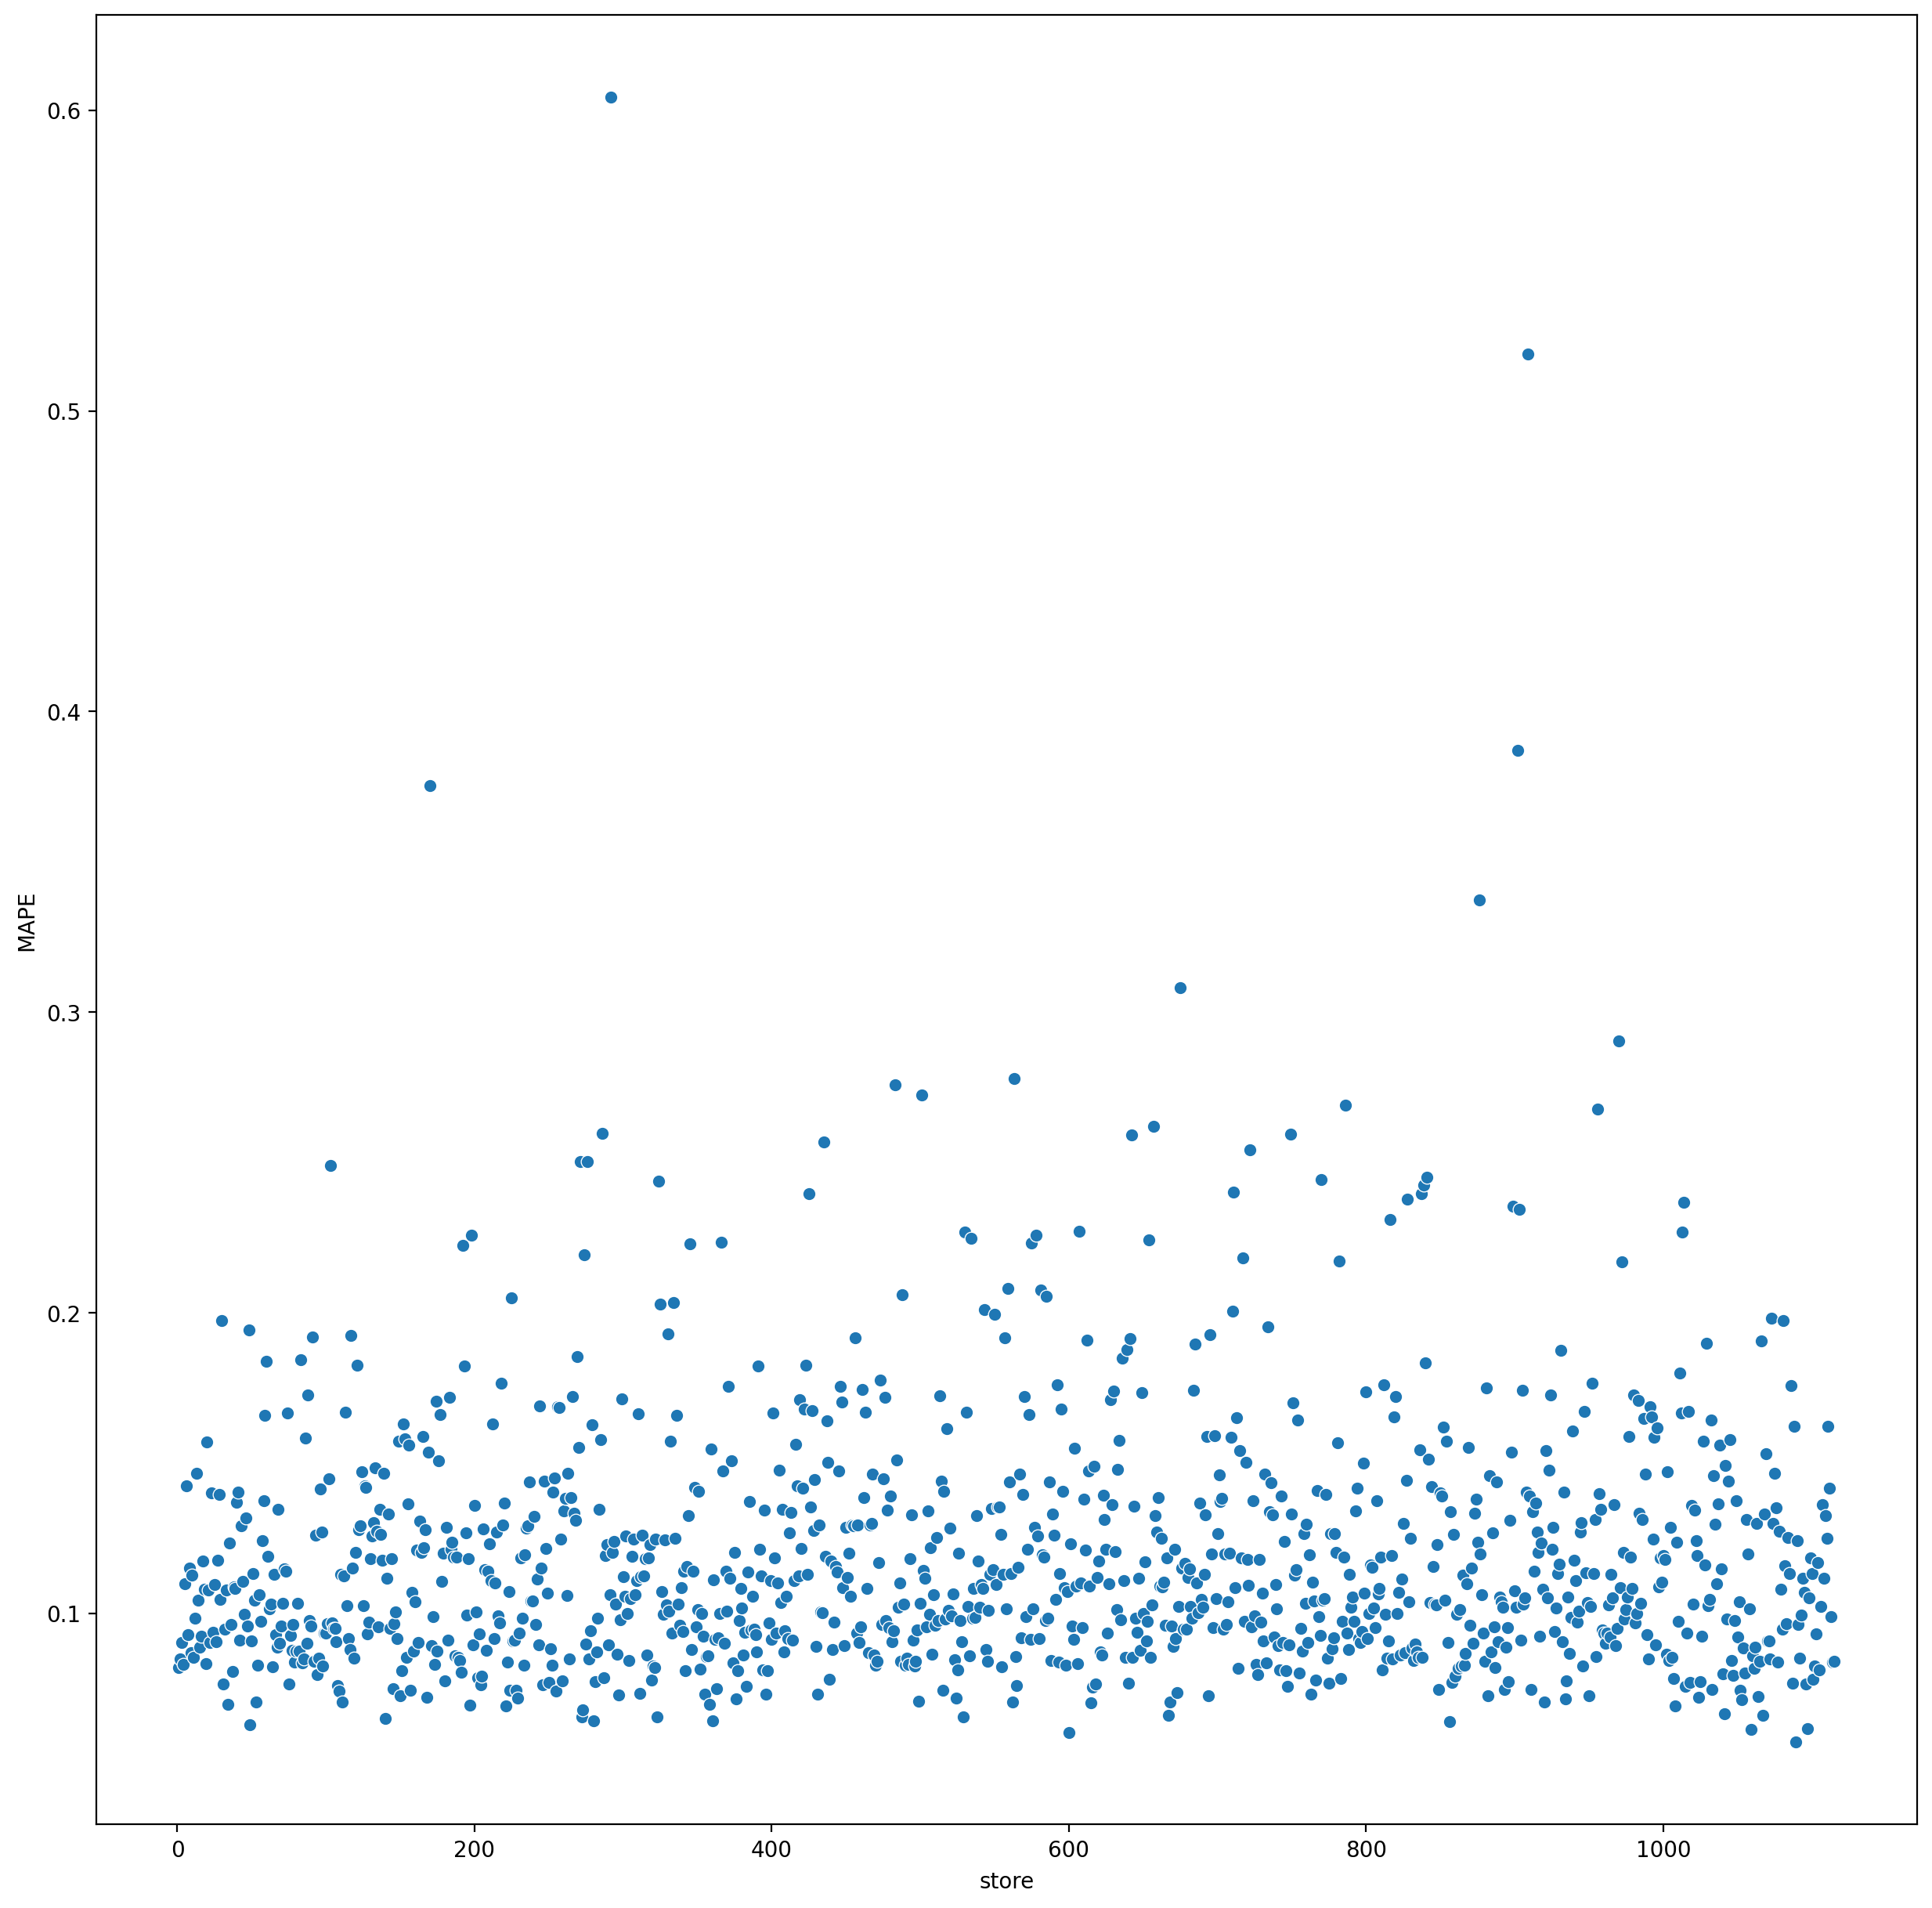

In [210]:
#visualizar a posição do MAPE de cada loja, identificando as lojas com MAPE destoando da maioria
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 - Total Performance

In [215]:
df93 = df92[['predictions', 'worst_scenarios', 'best_scenarios', 'MAE', 'MAPE']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0:'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenarios,Values
0,predictions,"R$ 289,617,792.00"
1,worst_scenarios,"R$ 288,737,682.22"
2,best_scenarios,"R$ 288,737,682.22"
3,MAE,"R$ 880,115.36"
4,MAPE,R$ 134.08


## 9.3 - Machine Learning Performance

In [222]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

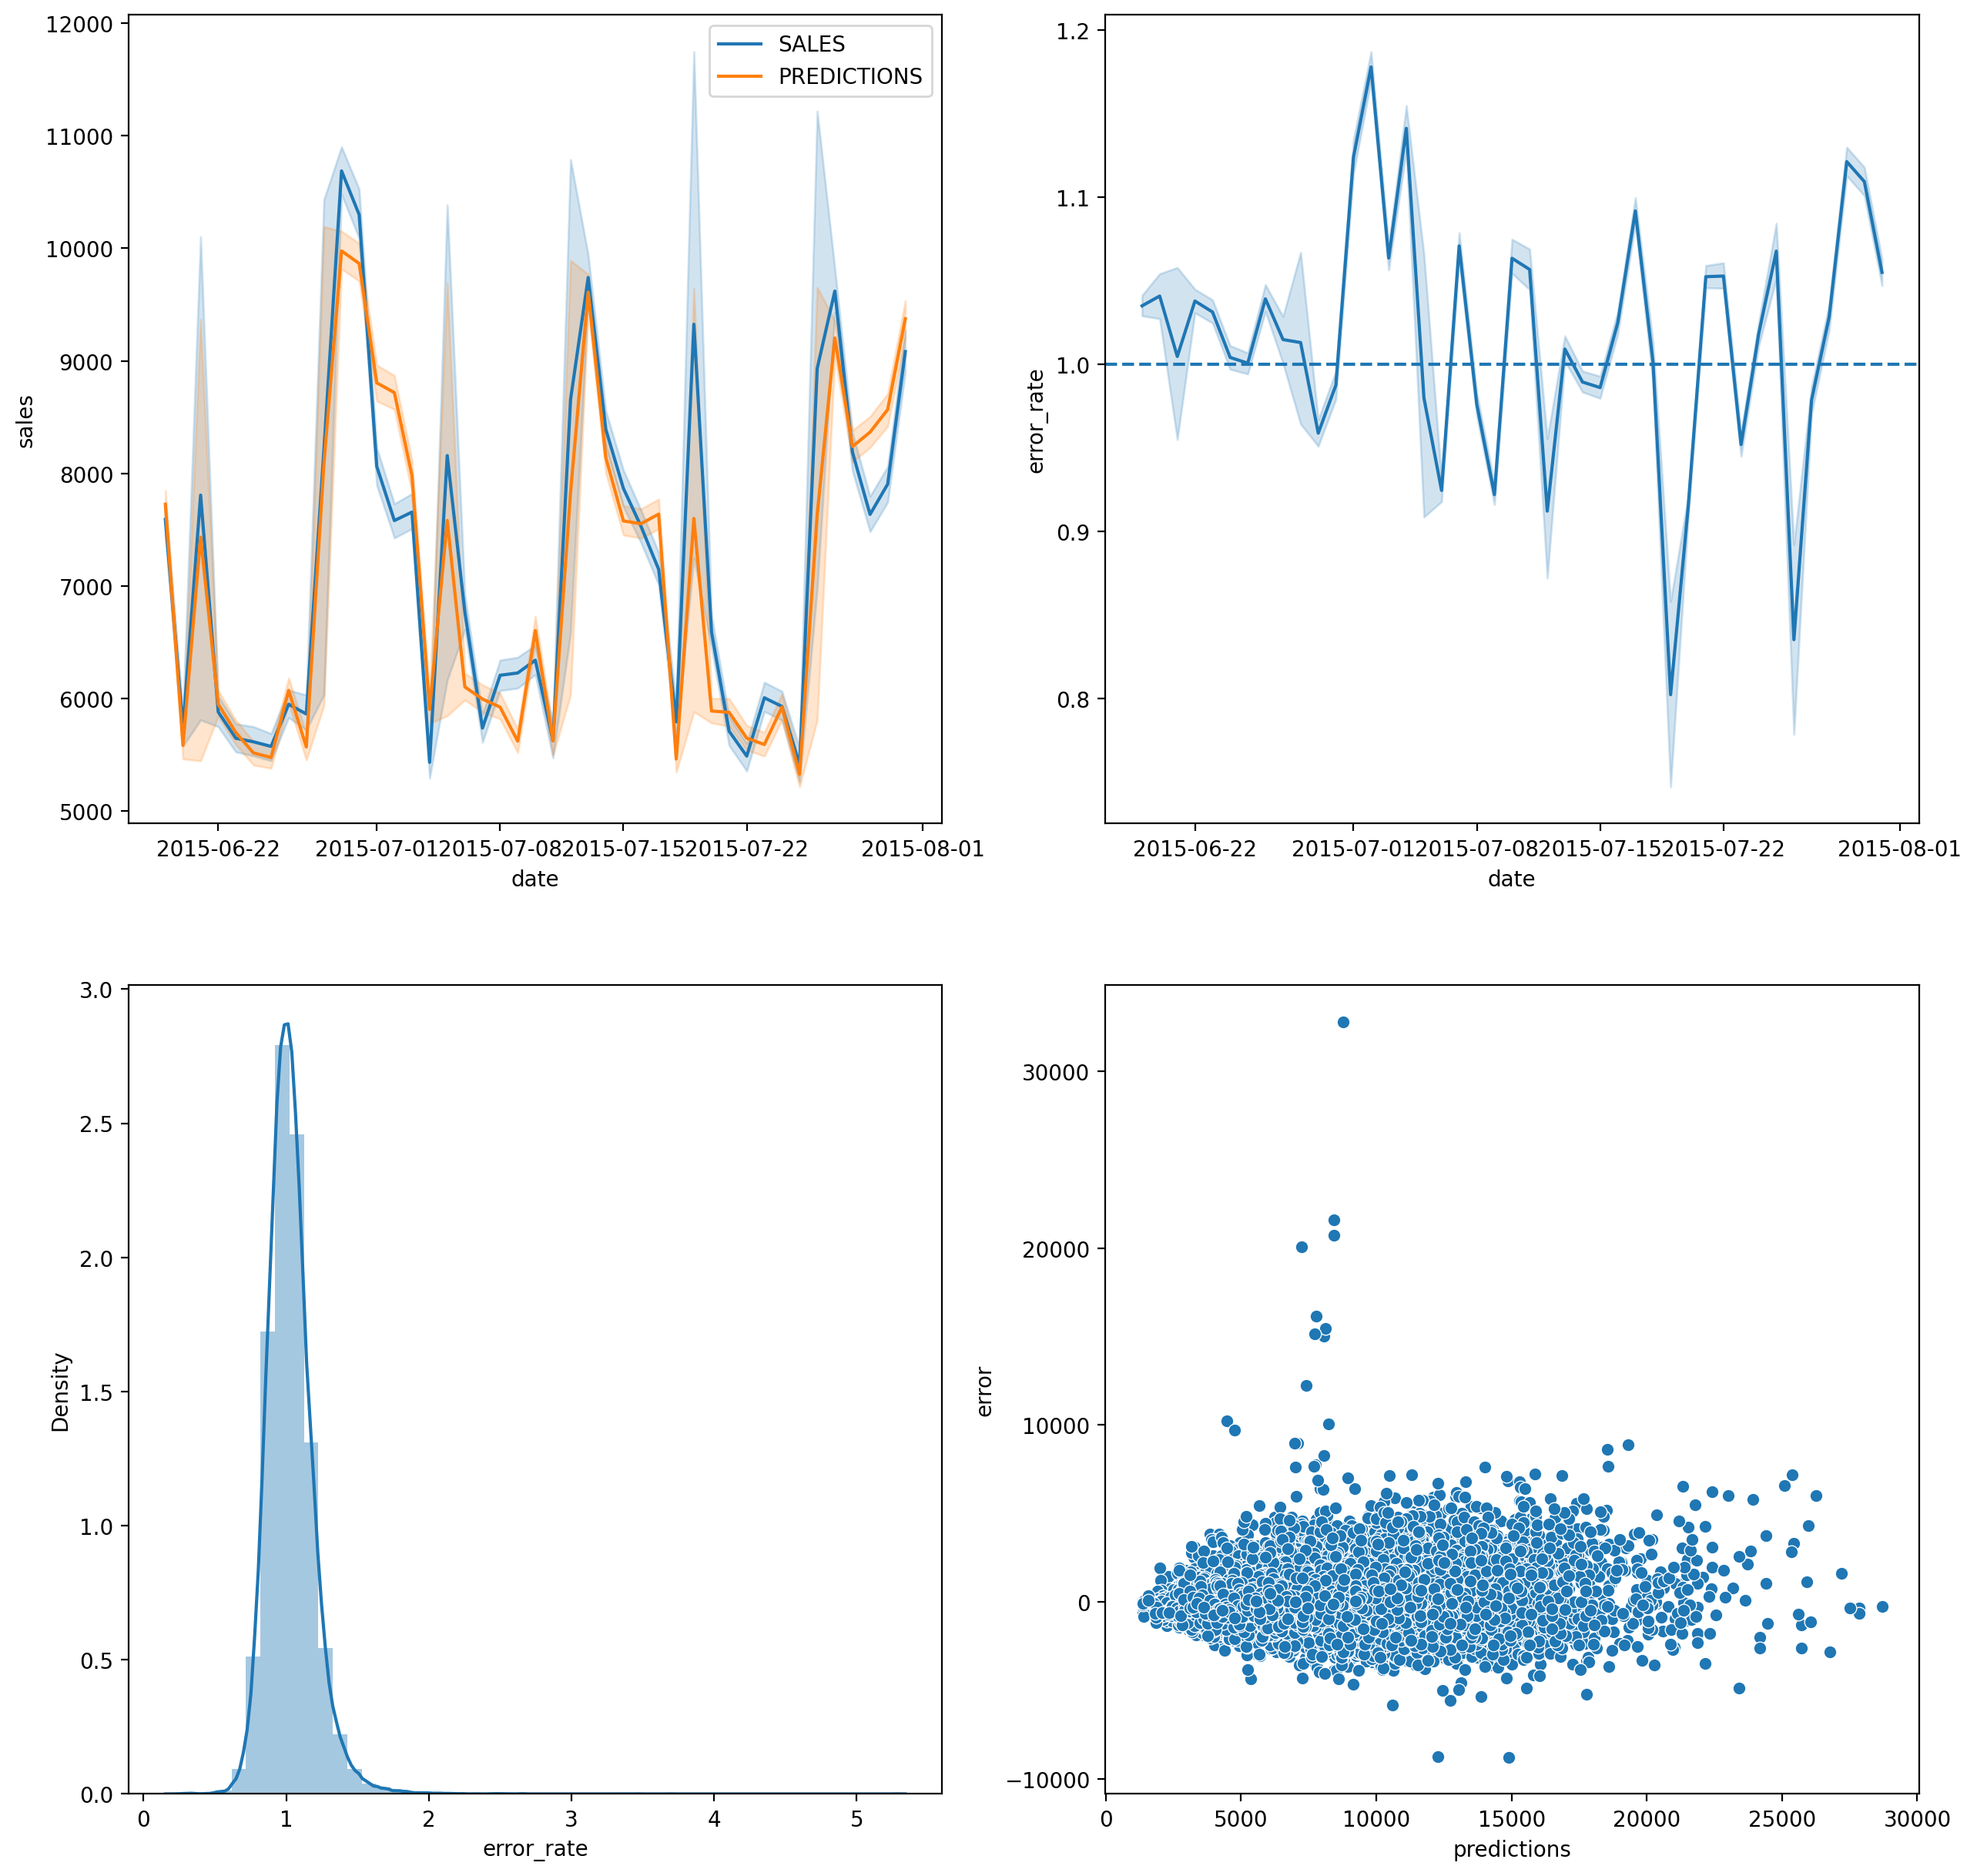

In [234]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error_rate'])
            
plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error']);